In [1]:
%matplotlib notebook

from sympy import *
from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
degree = UNITS.degree
radian = UNITS.radian

In [3]:
x_sym = symbols('x_sym')

In [4]:
# condition = Condition(x=
#                      y =
#                      g = 9.8 * m/s**2,
#                      mass =
#                      length =
#                      width =
#                      height =
#                      rho =
#                      C_d=
#                      angle =
#                      v_in =
#                      duration = 100 * s )

In [5]:
condition = Condition(g = 9.8,
                     point_a = (0.0, 3.0),
                     point_b = (3.0, 0.0))

In [32]:
def make_system_linear(condition=condition, a=None, b=None):
    unpack(condition)
    
    if b is None:
        b = point_a[1]
        
    if a is None:
        # If there is no ramp_func, make a linear one connecting A and B
        # f(x) = a*x + b
        a = (point_a[1] - point_b[1])/(point_a[0] - point_b[0])
        
    ramp_func = linear_func(x_input=0, a=a, b=b)
    init = State(x=point_a[0], y=point_a[1], v=0)
    system = System(init=init, condition=condition, ramp_func=ramp_func, a=a, b=b, t0=0, dt=0.001)
    return system

In [7]:
def linear_func(x_input, a, b):
    """
    f(x) = a*x_sym + b
    x from 0 to infinity
    returns: function f(x_sym) at x = x_threshold
    """
    if x_input < -b / a:
        return x_sym * a + b
    else:
        return 0

In [8]:
def quadratic_func(a, b, c):
    """
    f(x) = a*x_sym^2 + b*x_sym + c
    x from 0 to infinity
    returns: function f(x_sym) at x = x_threshold
    """
    return a*x_sym**2 + b*x_sym + c

In [9]:
def dif(function):
    """
    Differentiate a function f(x), must have x_sym in the function
    """
    return diff(function)

In [10]:
def update_func(system):
    #unpack(system)
    
    # Find direction of v based on ramp_func slope at x
    system.ramp_func = linear_func(system.x, system.a, system.b)
    system.ramp_dif = dif(system.ramp_func)

    slope_a = system.ramp_dif.subs(x_sym, system.x)
   
    alpha = sympy.atan(slope_a)
    
    # Find magnitude of v based on acceleration/gravity
    acceration = -system.condition.g * sympy.sin(alpha)
    system.v = system.v + acceration * system.dt
    
    # Find v_x and v_y from v_direction and magnitude
    v_x = system.v * sympy.cos(alpha)
    v_y = system.v * sympy.sin(alpha)
    
    system.x = system.x + v_x * system.dt
    system.y = system.y + v_y * system.dt

    return State(x=system.x, y=system.y, v=system.v)

In [11]:
def run_simulation(system, update_func):    
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init

    system.t = system.t0
    system.x = system.init.x
    system.y = system.init.y
    system.v = system.init.v
    
    while system.x < system.condition.point_b[0]:
        system.t += system.dt
        frame.loc[system.t] = update_func(system)
        
    system.results = frame

In [16]:
# Best in theory = system_0
system_0 = make_system_linear(condition=condition, a=-3/(3-sqrt(3)), b=3)
system_1 = make_system_linear(condition=condition)
system_2 = make_system_linear(condition=condition, a=-4, b=3)

run_simulation(system_0, update_func)
run_simulation(system_1, update_func)
run_simulation(system_2, update_func)

<IPython.core.display.Javascript object>


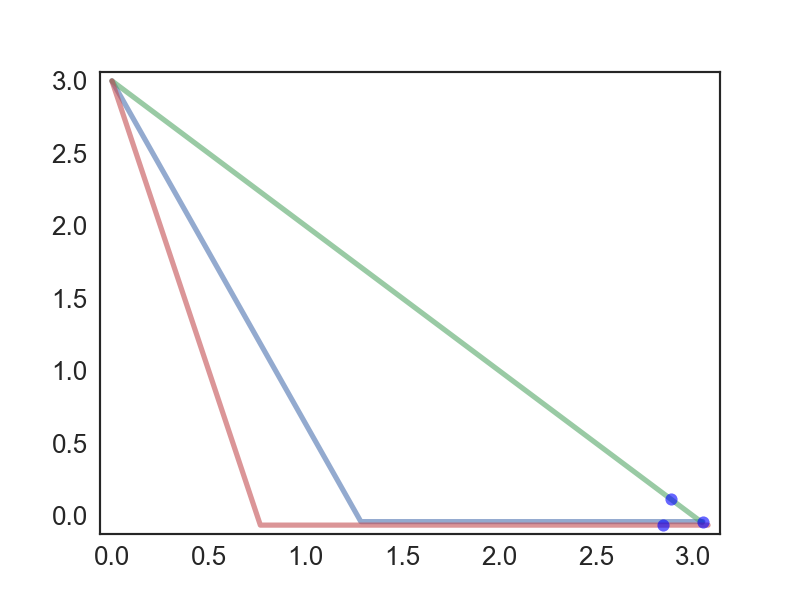

In [40]:
newfig()
frame0 = system_0.results
frame1 = system_1.results
frame2 = system_2.results
plot(frame0.x, frame0.y)
plot(frame1.x, frame1.y)
plot(frame2.x, frame2.y)

# Animate 2D
for x0, y0, x1, y1, x2, y2 in zip(frame0.x, frame0.y, frame1.x, frame1.y, frame2.x, frame2.y):
    plot([x0, x1, x2], [y0, y1, y2], 'bo', update=True)
    sleep(0.01)

In [43]:
def sweep_slopes():
    """
    Sweep the values of slopes
    """
    a_sweep = linspace(-5, -1, 40)
    t_series = SweepSeries()
    for a in a_sweep:
        system = make_system_linear(condition=condition, a=a, b=3)
        run_simulation(system, update_func)
        t_series[a] = system.t

    return t_series

t_series = sweep_slopes()

<IPython.core.display.Javascript object>


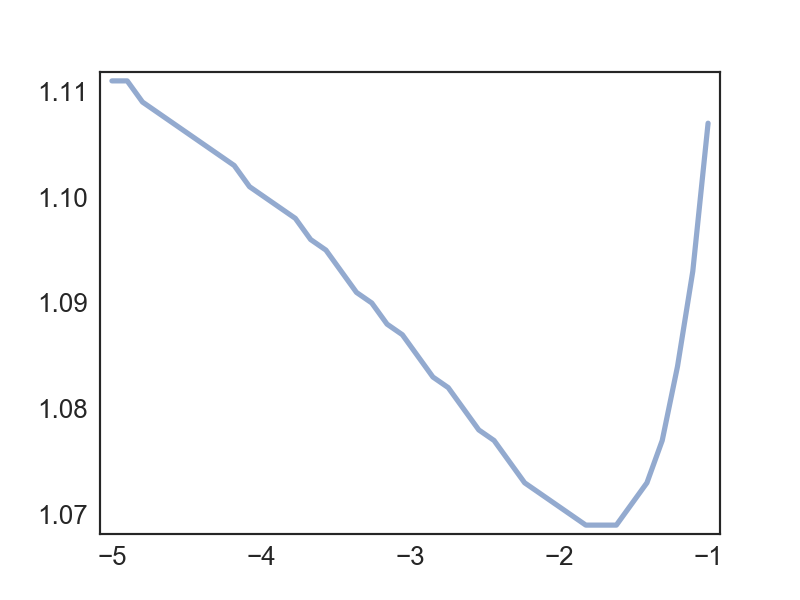

In [44]:
newfig()
plot(t_series)